# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### A. Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### B. Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### C. Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

**Reviews: organización de data**

In [2]:
contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 10
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

In [3]:
data_reviews = pd.DataFrame(data_reviews)

In [4]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,76561198003030375,Product received for free,NaN
4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,76561198353396844,NaN,NaN


**Se crea un dataset del archivo original, el cual queda con un poco menos de registros pero con las mismas columnas, en este dataset se ven campos relevantes como el nombre del juego, del usuario, las horas jugadas**

In [353]:
#Creo el archivo new_data_reviews.csv con la información del dataset data_reviews, esto con el fin de no tener que generarlo 
#cada vez que lo requiera
data_reviews.to_csv('new_data_reviews.csv')

#### Games: organización de data

In [6]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [354]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


__Sacamos un dataset del archivos de juegos y podemos observar columnas relevantes para recomendar como sentiment, metascore, genres,tags__

In [9]:
## Creamos el archivo new_data_games.csv para no tener que generarlo cada vez que lo necesitemos
data_games.to_csv('new_data_games.csv')

### A. ANÁLISIS EXPLORATORIO DE DATOS

#### - ANÁLISIS INICIAL

__Qué es Steam?__  
Steam es una plataforma digital de video juegos desarrollada por Valve, nació en septiembre del 2003, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 3000 juegos, lo que lo convierte en una plataforma ideal para el tipo de trabajo que aquí se presenta. El conjunto de datos contiene registros de más de 3000 juegos y aplicaciones.  Steam se lanzó como un cliente de software independiente, como una forma de que Valve proporcionara actualizaciones automáticas para sus juegos y se expandió para incluir juegos de editores externos. 

De acuerdo con la popularidad del juego, la similitud de la descripción del juego, la calidad del juego y la preferencia del jugador por el juego, recomiendan el juego correspondiente al jugador del juego, de modo que Steam obtenga un mayor grado de satisfacción del cliente.

__Se importan las librerías necesarias para trabajar en la consigna__

In [357]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset   
from surprise import Reader # lector de Surprise!
from surprise.model_selection import train_test_split
# quita calificacione de usuario-película de forma aleatoria s/ toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a una película
import os
from collections import defaultdict
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering 
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
import warnings


#### DATA REVIEW

In [358]:
##Cargamos el archivo new_data_reviews, archivo con extension .csv que tiene información de las
## reseñas dadas por los usuarios
new_data_review = pd.read_csv('new_data_reviews.csv')

In [359]:
new_data_review.shape # Filas y columnas

(779307, 13)

* *El Dataset de reseñas, cuenta con **779.307 Filas**, y **13 Columnas**.*

In [360]:
new_data_review.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


In [361]:
new_data_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779307 entries, 0 to 779306
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    779307 non-null  int64  
 1   username      779289 non-null  object 
 2   hours         776670 non-null  float64
 3   products      777741 non-null  float64
 4   product_id    779307 non-null  int64  
 5   page_order    779307 non-null  int64  
 6   date          779307 non-null  object 
 7   text          777468 non-null  object 
 8   early_access  779307 non-null  bool   
 9   page          779307 non-null  int64  
 10  user_id       317340 non-null  float64
 11  compensation  14588 non-null   object 
 12  found_funny   120164 non-null  float64
dtypes: bool(1), float64(4), int64(4), object(4)
memory usage: 72.1+ MB


__new_data_reviews.csv:__ Tiene informacion sobre las reseñas que realizaron los usuarios sobre los juegos que bajaron en dicha plataforma. Aquí la descripción de algunos de sus principales atributos son:
- "username" 
- "hours"(horas que ese usuario jugo a ese juego)
- "products" (es la cantidad de productos que el usuario compro en la plataforma)?
- "product_id" (identificacion numerica y unica del juego)
- "date" (fecha en que el usuario realizo la reseña)
- "text" (texto con observaciones del usuario)
- "user_id" (id del usuario que realiza la reseña o calificación)
- "found_funny" (las reseñas que realiza el usuario pueden ser marcadas como "funnys" por otros usuarios. Este indicador numerico es la cantidad de "calificaciones funny" que su reseña obtuvo)

In [362]:
# Información del descriptiva del dataset
new_data_review.describe().round(1)

,Unnamed: 0,hours,products,product_id,page_order,page,user_id,found_funny
count,779307.0,776670.0,777741.0,779307.0,779307.0,779307.0,3.173400e+05,120164.0
mean,389653.0,111.8,237.0,251489.8,4.4,893.6,7.656120e+16,7.7
std,224966.7,390.1,486.0,149975.4,2.9,1928.3,1.007694e+08,72.5
min,0.0,0.0,1.0,10.0,0.0,1.0,7.656120e+16,1.0
25%,194826.5,4.0,45.0,203770.0,2.0,53.0,7.656120e+16,1.0
50%,389653.0,15.3,110.0,252490.0,4.0,238.0,7.656120e+16,1.0
75%,584479.5,59.6,246.0,346110.0,7.0,829.0,7.656120e+16,3.0
max,779306.0,28164.0,13540.0,773900.0,9.0,18371.0,7.656120e+16,6524.0


__Podemos ver la media de la cantidad de horas 111 y que la cantidad de horas jugadas de los usuarios es de 776670
tambien podemos observar columnas que podamos utilizar para la recomendación como hours o found_funny, el product_id importante para la identificación del juego__

__DATA GAMES__

In [363]:
new_data_games = pd.read_csv('new_data_games.csv')

In [364]:
new_data_games.shape # Filas y columnas

(32135, 17)

* *El Dataset de juegos, cuenta con **32.135 Filas**, y **17 Columnas**.*

In [365]:
new_data_games.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


In [366]:
new_data_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      32135 non-null  int64  
 1   publisher       24073 non-null  object 
 2   genres          28852 non-null  object 
 3   app_name        32133 non-null  object 
 4   title           30085 non-null  object 
 5   url             32135 non-null  object 
 6   release_date    30068 non-null  object 
 7   tags            31972 non-null  object 
 8   discount_price  225 non-null    float64
 9   reviews_url     32133 non-null  object 
 10  specs           31465 non-null  object 
 11  price           30758 non-null  object 
 12  early_access    32135 non-null  bool   
 13  id              32133 non-null  float64
 14  developer       28836 non-null  object 
 15  sentiment       24953 non-null  object 
 16  metascore       2607 non-null   float64
dtypes: bool(1), float64(3), int64(1

__new_data_games.csv:__ Tiene informacion sobre muchos de los juegos que ofrece la plataforma. Sus principales atributos son:
- "publisher" (editor) 
- "genres"(generos)
- "title"(nombre del juego)
- "release_date" (fecha en que se comenzo a comercializar)
- "tags" (etiquetas)
- "specs" (caracteristicas de juego)
- "id" (identificacion numerica y unica del juego)
- "developer" (desarrollador)
- "sentiment"(asigna al juego un valor caracteristico en funcion de la valoracion que le pusieron los usuarios si es mas o menos valorado; tambien diferencia los casos en que no hay suficientes reseñas para evaluarlo)
- "metascore" ( valoracion numerica de 1 a 100, que tiene ese juego en la web)

In [367]:
new_data_games.describe().round(1)

,Unnamed: 0,discount_price,id,metascore
count,32135.0,225.0,32133.0,2607.0
mean,16067.0,11.9,451757.4,72.3
std,9276.7,17.5,182714.0,10.8
min,0.0,0.5,10.0,20.0
25%,8033.5,1.4,329280.0,66.0
50%,16067.0,4.2,452060.0,74.0
75%,24100.5,22.7,593400.0,80.0
max,32134.0,140.0,2028850.0,96.0


In [368]:
print(new_data_games['sentiment'].unique())

[nan 'Mostly Positive' 'Mixed' '1 user reviews' '3 user reviews'
 '8 user reviews' 'Very Positive' 'Overwhelmingly Positive'
 '6 user reviews' '5 user reviews' '2 user reviews' 'Very Negative'
 'Positive' 'Mostly Negative' '9 user reviews' 'Negative' '4 user reviews'
 '7 user reviews' 'Overwhelmingly Negative']


- __El atributo "sentiment"__: analizando un poco mas este campo encuentro que tiene los valores anteriores, algunos los veo claro para calificar un juego pero otros como "1 user reviews", no son claros. Decido evaluar la cantidad de registros por cada valor diferente

In [369]:
## revisando los valores que se encuentran en la columna Sentiment
print(new_data_games['sentiment'].value_counts())

Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     303
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: sentiment, dtype: int64


__Observo que existen muchos registros para los valores de # user reviews, los cuales no me dan claridad de la calificación asignada, si es buena o mala, no me queda claro como poder recomendar juegos de acuerdo a esos valores__

### - Valores Faltantes: 
Se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna.

__DATA REVIEW Y DATA GAMES__

In [370]:
new_data_review.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` 98% (764.719);*  
    *2. `found_funny` 86% (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

__DATA GAMES__

In [371]:
new_data_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todos las Variables tienen elementos faltantes. Detallamos las principales:*  
    *1. `discount_price` 98% (31.910);*  
    *2. `metascore` 98% (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
    
* *Vemos que el `id` de los juegos, tienen 2 valores faltantes.*

__Reseñas por usuario__

In [372]:
CantidadReseñas = new_data_review.username.value_counts()
print(CantidadReseñas)

123          213
Alex         190
Chris        155
Nick         143
Matt         137
            ... 
lucimon        1
JishJoshy      1
Rikkord        1
Big boi        1
Yevaud         1
Name: username, Length: 540338, dtype: int64


__Distribución de las reseñas__

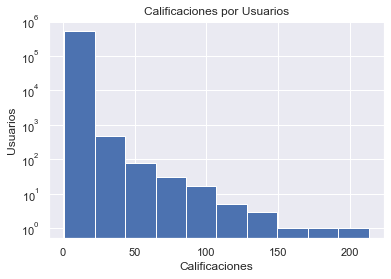

In [373]:
plt.hist(CantidadReseñas,log=True)
plt.xlabel('Calificaciones')
plt.ylabel('Usuarios')
plt.title('Calificaciones por Usuarios')
plt.show()

Podemos observar que la mayoría de los usuarios no tienen la costumbre de calificar y alrededor del 10% son los que mas 
califican

In [374]:
# Cantidad de usuarios que han calificado
print (len(new_data_review['username'].unique())) 

540339


In [376]:
# Cantidad de juegos
print (len(new_data_games['id'].unique()))

32133


In [257]:
# Cantidad de juegos calificados
print (len(new_data_review['product_id'].unique()))

12665


- #### Reseñas a partir de la calificaciones __sentiment.__ De la data de Games

Text(0.5, 1.0, 'Calificación Sentiment x Juego')

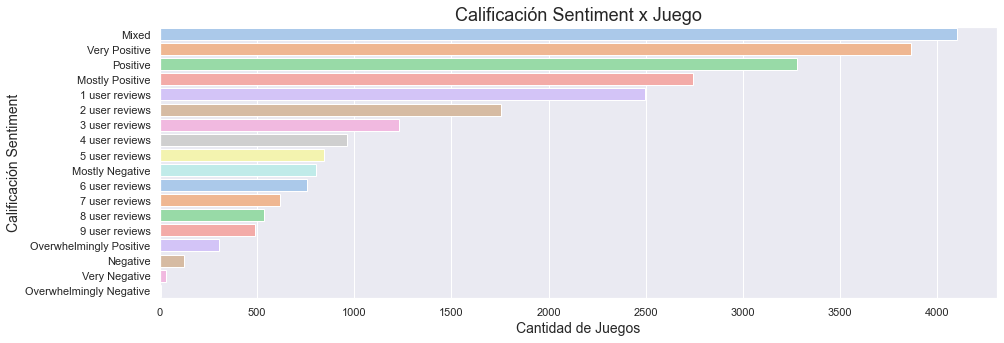

In [377]:
plt.subplots(figsize=(15, 5))

sns.countplot(data = new_data_games, y = 'sentiment', order = new_data_games['sentiment'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por Tipo')

plt.xlabel('Cantidad de Juegos',size=14)
plt.ylabel('Calificación Sentiment',size=14)
plt.title("Calificación Sentiment x Juego" ,size=18)

In [385]:
print(new_data_games.sentiment.count())

24953


_Se puede observar que la mayoría de calificaciones que dejan registradas en este Campo son positivas y que se tiene un total de 24953 registros con este valor, lo cual es un % bastante alto de todo el dataset con calificación en este campo_

- #### Reseñas a partir de la calificaciones __metascore.__ de la data de Games

In [378]:
print(new_data_games['metascore'].value_counts())

80.0    125
74.0    107
77.0    104
75.0    103
76.0    102
       ... 
42.0      1
33.0      1
34.0      1
20.0      1
29.0      1
Name: metascore, Length: 70, dtype: int64


In [379]:
## Cantidad de juegos calificados por este atributo
print(new_data_games['metascore'].value_counts().sum())

2607


2607 son muy pocos registros que tienen este campo, lo cual me hace descartarlo como campo para recomendar

Text(0.5, 1.0, 'Número de Calificaciones por puntaje')

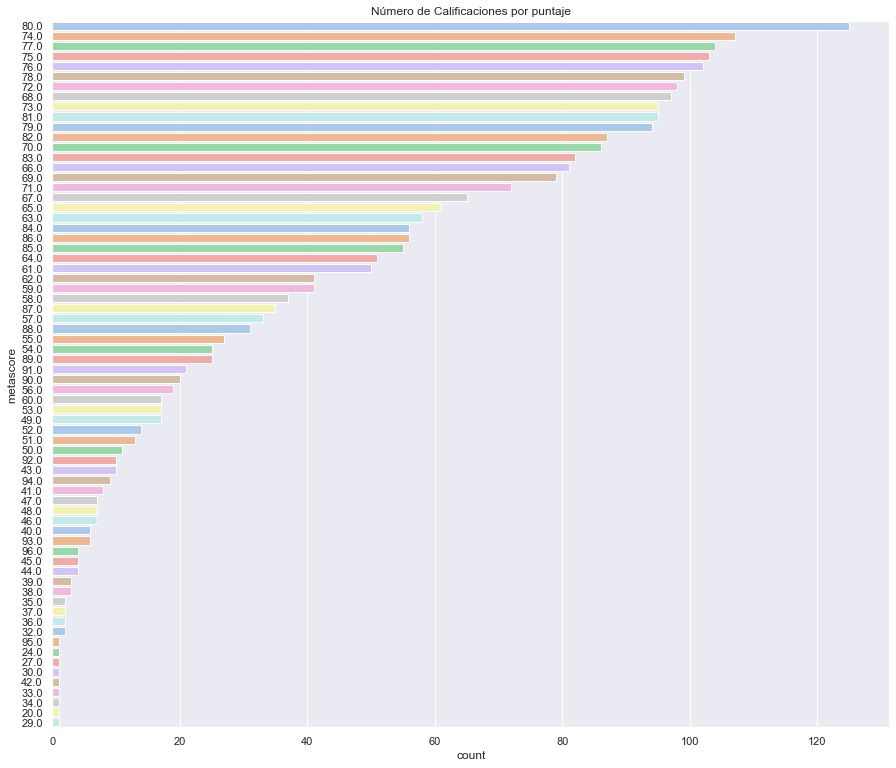

In [387]:
plt.figure(figsize = (15,13))
sns.countplot(data = new_data_games, y = new_data_games ["metascore"], order = new_data_games['metascore'].value_counts().index, palette='pastel')
plt.title('Número de Calificaciones por puntaje')

In [ ]:
Con lo anterior se puede observar el comportamiento de calificar a juegos con altos puntajes

### B. FILTRO COLABORATIVO

* __Recomendación Colaborativa:__ se buscan Usuarios similares en sus gustos, y de acuerdo a ello, se usan los productos que ellos consumen para recomendarlos (que yo no he usado, consumido, escuchado, etc.). Se utiliza lo que se sabe de mí y en función de ello se buscan usuarios que se parecen a mí.
    - Ventajas: no necesito tener info acerca de los productos.
    - Desventajas: necesitamos tener la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
    
* Necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

CASO PARTICULAR STEAM
* No hay registros tanto en el sitio web Steam, sobre las calificaciones continuas de estos usuarios. En realidad, en la plataforma, los usuarios sólo dan "Recomendación" o "No Recomendación", esto no nos da mucha información sobre el grado de gustarles un juego, incluso en el sitio web del usuario, todavía no hay ningún mecanismo sobre las calificaciones continuas, como algún puntaje.
* Por lo cual para obtener calificaciones continuas sobre el gusto de los usuarios por los juegos, debemos suponer un mecanismo de calificación de los juegos, otro campo del archivo que nos pueda dar información sobre el gusto de los usuarios sobre los juegos puede ser por `las horas jugadas`, podemos asumir que el tiempo de juego es una información sobre los intereses de los usuarios.

Seleccionamos aquellos **features que nos seran útiles** a la hora de aplicar un **filtro colaborativo**.

#### DATA REVIEWS.

In [389]:
df_review = new_data_review[['username','hours','product_id']]
print(df_review.shape)
df_review.head()

(779307, 3)


,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140


#### Preprocesamiento de datos (Tratamiento de datos nulos)

In [390]:
df_review.isnull().sum()

username        18
hours         2637
product_id       0
dtype: int64

_- Los valores fatantes representan menos del 0,3% del total de instancias, por lo que se procede a eliminarlos, ya que no deberían generar grandes distorsiones en el dataset_

In [391]:
## Borro los valores faltantes
df1_review = df_review.dropna()

In [392]:
## Confirmo que se hayan borrado
df1_review.isnull().sum()

username      0
hours         0
product_id    0
dtype: int64

In [393]:
## Tamaño del nuevo dataset
print(df1_review.shape)

(776652, 3)


### Tratamiento de outliers (Tratamiento de Outliers)

Text(0, 0.5, 'distribucion')

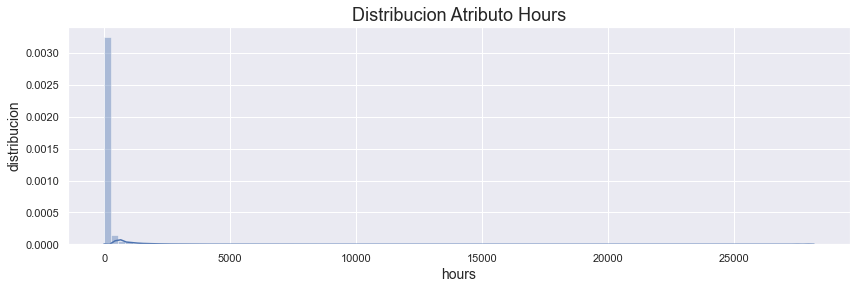

In [394]:
## Distrubución de las horas

plt.subplots(figsize=(14,4))

plt.title("Distribucion Atributo Hours" ,size=18)
sns.distplot(df1_review ["hours"],bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)

<AxesSubplot:ylabel='hours'>

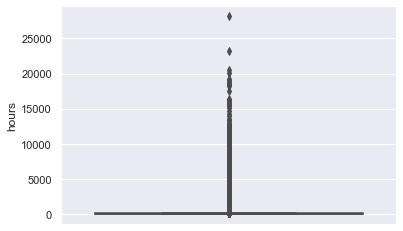

In [395]:
sns.boxplot(data = df1_review, y = "hours")

In [396]:
## Utilizando la regla de las 3 sigmas

valorMedio_hours = df1_review.hours.mean()
std_hours = df1_review.hours.std()
minimo_hours = valorMedio_hours - 3*std_hours
maximo_hours = valorMedio_hours + 3*std_hours
mascara_outliers = np.logical_or(df1_review.hours < minimo_hours, df1_review.hours > minimo_hours)

In [397]:
mascara_outliers.sum()

776652

In [398]:
df1_review[mascara_outliers]

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


In [399]:
df2_review = df1_review[(df1_review.hours >= minimo_hours) & (df1_review.hours <= maximo_hours)]
df2_review.shape

(763677, 3)

In [400]:
df2_review.describe()

,hours,product_id
count,763677.000000,763677.000000
mean,72.970961,253079.907385
std,163.635493,149415.745319
min,0.000000,10.000000
25%,3.900000,204300.000000
50%,14.700000,252490.000000
75%,54.800000,346560.000000
max,1281.900000,773900.000000


La media es: 72.97096141431517
La desviación estandar es: 163.63549325432086


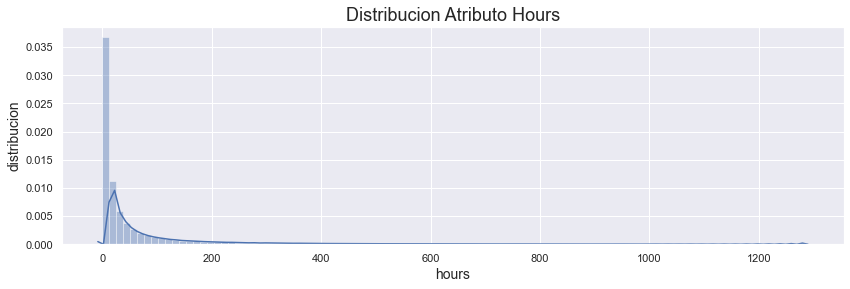

In [401]:
# Distribución de horas después del tratamiento de outliers

plt.subplots(figsize=(14,4))

plt.title("Distribucion Atributo Hours" ,size=18)
sns.distplot(df2_review ["hours"],bins=100)
plt.xlabel('hours',size=14)
plt.ylabel('distribucion',size=14)

print('La media es:',df2_review['hours'].mean())
print('La desviación estandar es:',df2_review['hours'].std())

<AxesSubplot:ylabel='hours'>

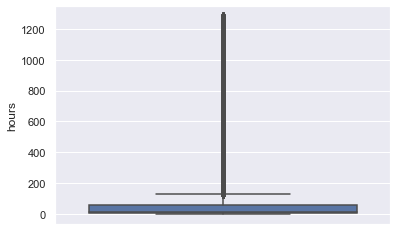

In [402]:
sns.boxplot(data = df2_review, y = "hours")

#### ENCODERS
A pesar que no se requiera ya que la libreria Surprise permite trabajar feature sin categorizar, se decide asignarle un Id a cada 
usuario único, a fin de facilitar comparaciones a futuro.

In [277]:
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

le = LabelEncoder()
df2_review['username'] = le.fit_transform(df2_review['username'])


display(df2_review.head())


,username,hours,product_id
0,61272,0.1,725280
1,26274,13.2,328100
2,426434,0.1,725280
3,341420,7.8,631920
4,494284,8.2,35140


#### Definición del rating a utilizar

Tratando que las horas se distribuyan equitativamente para crear un rating hasta 5

In [405]:
df3 = df2_review

In [406]:
bins = [0, 100, 200, 300, 500, 20573]


labels =[1,2,3,4,5]

df2_review['rating'] = pd.cut(df2_review['hours'], bins,labels=labels)

warnings.filterwarnings('ignore')

In [407]:
df2_review['rating'].value_counts(normalize=True).round(7)

1    0.832097
2    0.071143
5    0.034903
3    0.031222
4    0.030635
Name: rating, dtype: float64

In [408]:
df3_review = df2_review.dropna()

In [409]:
df3_review['rating'] = df3_review['rating'].astype(int)

warnings.filterwarnings('ignore')

In [410]:
df3_review= df3_review[['username','product_id','rating']]
df3_review

,username,product_id,rating
0,Chaos Syren,725280,1
1,Ariman1,328100,1
2,freakfantom,725280,1
3,The_Cpt_FROGGY,631920,1
4,the_maker988,35140,1
...,...,...,...
779301,SepticFalcon,252490,4
779302,Vidaar,252490,5
779303,Nikolai Belinski,252490,1
779304,RancorZealot,252490,3


<AxesSubplot:title={'center':'Cantidad de Calificaciones por Rating'}, xlabel='rating', ylabel='count'>

<Figure size 432x288 with 0 Axes>

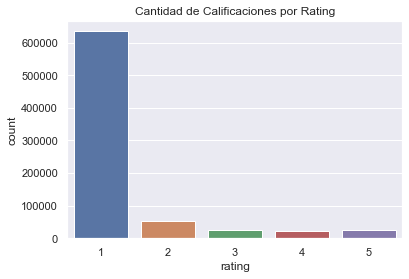

In [412]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=df3_review, x ='rating')

Con esta distribución no equitativa la mayoria del rating queda con el valor de 1

_Distribución equitativa del rating: Decido utilizar la siguiente función para realizar una distribución equitativa de los datos_

In [413]:
df3_review = df3

df3_review['rating'] = pd.qcut(df3_review.hours, 5, labels=['1', '2', '3', '4', '5'])

warnings.filterwarnings('ignore')


In [414]:
df3_review = df3_review[['username','rating','product_id']]
df3_review

,username,rating,product_id
0,Chaos Syren,1,725280
1,Ariman1,3,328100
2,freakfantom,1,725280
3,The_Cpt_FROGGY,2,631920
4,the_maker988,2,35140
...,...,...,...
779301,SepticFalcon,5,252490
779302,Vidaar,5,252490
779303,Nikolai Belinski,4,252490
779304,RancorZealot,5,252490


<AxesSubplot:title={'center':'Cantidad de Calificaciones por Rating'}, xlabel='rating', ylabel='count'>

<Figure size 432x288 with 0 Axes>

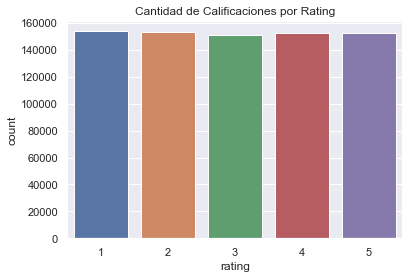

In [415]:
fig = plt.figure()
fig, ax = plt.subplots(figsize = (6,4))
plt.title('Cantidad de Calificaciones por Rating')
sns.countplot(data=df3_review, x ='rating')

### _Rating a utilizar_
Decido utilizar el rating anterior el cual muestra una distribución equitativa del rating de acuerdo a la cantidad de los datos

In [416]:
# Se pasa el campo rating a entero
df3_review['rating'] = df3_review['rating'].astype(int)

__Eliminamos la columna de `hours`, dejando en su remplazo la confeccionada de `rating`y voy a organizar el dataframe de ordenando los atributos para que queden igual que lo requiere Surprise.__

In [417]:
df4_review = df3_review[['username','product_id','rating']]

In [418]:
df4_review.to_csv('df4_review_listo.csv', index= False)

#### DATA GAMES.

- Selecciono los features que serán útiles para realizar las recomendaciones y que aporten al realizar la unión con el data frame final del dataframe de reviews, para ello utilizaré las columnas _id y title_

In [419]:
df_games1 = pd.read_csv('new_data_games.csv', encoding = "ISO-8859-1", usecols = [4,13])
print(df_games1.shape)
df_games1.head()

(32135, 2)


,title,id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,å¼¹ç¸äºº2222,767400.0
4,NaN,773570.0


__Intercambiando las columnas, y renombrando la de `id`, a fin de que coincida con el dataset de Reviews donde se nombra "product_id".__

In [420]:
df_games1 = df_games1[['id','title']]
df_games1.head()

,id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN


In [421]:
df_games2 = df_games1.rename(columns={'id':'product_id'})
df_games2

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


#### Preprocesamiento de datos (Tratamiento de datos nulos)

In [422]:
df_games2.isnull().sum()

product_id       2
title         2050
dtype: int64

#### Los valores fatantes representan el 6,4% del total de instancias. Se procede a eliminar todos ellos, ya que sin `product_id` no podemos cruzar los datos con el dataframe de Reviews, y sin `title` no podremos realizar las recomendaciones.

In [423]:
df_games3 = df_games2.dropna()
print(df_games3.isnull().sum())
print(df_games3)

product_id    0
title         0
dtype: int64
       product_id                     title
0        761140.0       Lost Summoner Kitty
1        643980.0                 Ironbound
2        670290.0   Real Pool 3D - Poolians
3        767400.0             å¼¹ç¸äºº2222
5        772540.0     Battle Royale Trainer
...           ...                       ...
32129    745400.0              Kebab it Up!
32130    773640.0            Colony On Mars
32131    733530.0  LOGistICAL: South Africa
32132    610660.0             Russian Roads
32133    658870.0       EXIT 2 - Directions

[30084 rows x 2 columns]


### Concatenación: Organizando el dataframe final

__Indexacion - Indexamos `product_id` a fin de poder realizar el cruce con el Dataset de Review__

In [424]:
df_games3.dtypes

product_id    float64
title          object
dtype: object

In [425]:
#Pasamos el campo product_id a entero para realizar la indexación
df_games3[('product_id')] = df_games3['product_id'].astype(int)

In [426]:
df_games1 = df_games3.set_index('product_id', drop=True)
df_games1

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
772540,Battle Royale Trainer
...,...
745400,Kebab it Up!
773640,Colony On Mars
733530,LOGistICAL: South Africa


In [427]:
df_games1.dtypes

title    object
dtype: object

##### Luego, el tipo de dato de `pruduct_id` y `title` resultan ser **object**, siendo acorde para llevar a cabo nuestras recomendaciones a posteriori.

_Eliminamos los juegos repetidos, buscando los valores de product_id que están duplicados_

In [328]:
#Tamaño del nuevo data set
df_games1.shape

(30084, 1)

In [428]:
df_games1 = df_games1[~df_games1.index.duplicated(keep='first')]
df_games1.shape

(30083, 1)

_Solo se borra un registro lo cual indica que solo había un juego duplicado_

__Con el preprocesamiento anterior, obtenemos el dataset de GAMES final, con el cual vamos a realizar el cruce con el dataset de REVIEWS para empezar a trabajar con un dataset que nos permitira conocer la información de los gustos de los usuarios sobre los juegos y conocer los nombres de esos juegos.__

__¿Cuáles son los juegos más populares? ¿Cuántas calificaciones tienen? ¿Y los juegos menos populares?__

In [429]:
PopularidadJuegos = df4_review.product_id.value_counts()
PopularidadJuegos.index = df_games1.loc[PopularidadJuegos.index].title
PopularidadJuegos

title
Team Fortress 2                      14939
Rust                                  9341
Borderlands 2                         7265
Fallout 4                             6987
Grand Theft Auto V                    5895
                                     ...  
Crystal Picnic                           1
The Perks of Being a Wallflower          1
My Little Kitties                        1
Japanese Women - Animated Jigsaws        1
DP Animation Maker                       1
Name: product_id, Length: 12618, dtype: int64

El juego con mayor numero de reseñas es TEAM FORTRESS 2 con 14939 reseñas, le sigue RUST con 9341 reseñas
Los juegos con menos reseñas son My Little Kitties, Japanese Women, DP Amination Maker

__Modelo Benchmark: Para realizar el sistema de recomendacion con el metodo de filtro colaborativo vamos a usar la libreria Surprise.__

_Voy a utilizar como Benchmark al modelo que utiliza como referencia la libreria Surprise donde aplica sus algoritmos a un dataset de peliculas.
El rating utilizado es de 1 a 5. Igual que el que utilizaremos nosotros.
El algoritmo utilizado es AlgoBase.
El RMSE obtenido es 1.5_

### C. Modelo de Machine Learning

#### MODELO SVD #### 
__Hay muchos algoritmos en la libreria Surprise. Voy a utilizar SVD++ ya que presenta buen performance en el dataset de peliculas que utiliza Surprise como referencia__

In [433]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df4_review, reader)

trainset, testset = train_test_split(data, test_size=.25)

algo = SVDpp() 

algo.fit(trainset)

predictions = algo.test(testset)

In [434]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.1520


1.1520098409084945

__Con SVD++ con hiperparametros por default da un RMSE de df4_review: 1.1520__

### - Cross Validation

In [346]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df4_review, reader)

algo = SVDpp()

cross_validate(algo, data, cv=5)

{'test_rmse': array([1.14800064, 1.15186154, 1.15339272, 1.15213188, 1.15246194]),
 'test_mae': array([0.94526728, 0.94888496, 0.95123233, 0.95048039, 0.94961407]),
 'fit_time': (71.76743936538696,
  70.25347113609314,
  70.73297953605652,
  78.32950377464294,
  73.08798456192017),
 'test_time': (1.8279314041137695,
  1.9172043800354004,
  1.8536970615386963,
  1.8880035877227783,
  2.1840016841888428)}

__Con SVD++ con hiperparametros por default y CrossValidation de 5: RMSE de df4_review: 1.14__

### - GridSearch

In [349]:
from surprise.model_selection import GridSearchCV

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df4_review, reader)

algo = SVDpp()

param_grid = {'n_factors': [5,50],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)

gs.fit(data)

In [350]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

1.0993347306085164
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}


__Con SVD++ con GridSearch:__ RMSE de df4_review: 1.09

### Conclusiones Generales

#### Viendo los mejores RMSE que obtuvimos observamos que:
- __Aplicando GridSearch al dataset df4_review , da un mejor RMSE (1.09).__

#### Hagamos otro analisis pero con uno de los dos df creados como demo, donde la distribucion del rating fue solo optando por tomar el valor máximo de horas (20573), y lo dividiamos en 5 Bins. 

In [435]:
bins = [0, 4114.6, 8229.2, 12343.8, 16458.4, 20573]
labels =[1,2,3,4,5]

df3['rating'] = pd.cut(df3['hours'], bins,labels=labels)

warnings.filterwarnings('ignore')

In [436]:
df4=df3.dropna()

In [437]:
df4['rating'] = df4['rating'].astype(int)

warnings.filterwarnings('ignore')

In [438]:
df4= df4[['username','product_id','rating']]

In [439]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df4, reader)

trainset, testset = train_test_split(data, test_size=.25)

algo = SVDpp() 

algo.fit(trainset)

predictions = algo.test(testset)

In [440]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 0.0123


0.012293386158009428

- #### Con esta modalidad de clasificacion de rating el RMSE que logramos es de 0.0123. Lo que podemos deducir es que el atributo "hours" y su distribucion muy asimetrica es determinante para este analisis y puede llegar a estar distorsionando mucho los resultados de RMSE.

- #### Es probable que un RMSE de 1.09 lo consideremos un buen resultado para este sistema de recomendacion; pero que en la practica no haga buenas recomendaciones. 

#### Hay dos preguntas que no tienen una respuesta facil de acuerdo a la información que se tiene __en los jugadores que jugaron 0 hs__. Porque un usuario no jugo ni una hora un juego que compro, y porque escribio una reseña sobre un juego que no jugo? Aca seguramente tengamos que respondernos si el usuario lo compro por la plataforma Steam, pero decidio bajarlo a la pc y jugarlo por afuera de la plataforma impidiendo el conteo de las horas jugadas.

#### Las horas jugadas son contadas desde que el usuario compro el juego; pero logicamente no todos los usuarios compraron el juego en la misma fecha. Como los estamos considerando hasta ahora, si dos usuarios jugaron 100 hs un juego es lo mismo si lo compro hace un año que hace un mes. Tendriamos que normalizar esta distorsion de alguna manera.

#### No se está teniendo en cuenta la fecha en que el juego se liberó en la plataforma, un juego recién liberado es lógico tenga menos horas de usuarios jugadas que uno que lleve muchos años desde que se liberó

### D. INVESTIGACION

#### - La utilizacion de procesamiento de lenguaje natural para asignar un puntaje a cada reseña en funcion de la critica escrita que realizo.

#### - Realizar un un analisis basada en contenidos con el dataset de games, y utilizando los atributos de "sentiment", el puntaje de "metascort" y la fecha de liberación del juego.